# Impor Libraries

In [1]:
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN
from modules.predictors import DotPredictor, MLPPredictor
import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import os
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

from utils import *
from modules.graph import *

c:\Users\Vale\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#FIXME: el edge (1,2) es equivalente a (2,1)), es importante asegurarse de que ambos casos se asignen al mismo conjunto (entrenamiento, validación o prueba). La implementación actual, sin embargo, no garantiza esto.
#FIXME: Entrenamiento con unicamente nodos, areglar varanza (long tail) y normalizar 
#FIXME: porq me esta dando la validacion eso, ver ambos lados como se infieren??? 

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos
    * Predictor : MLPPredictor
    

## Entrenamiento

Done saving data into cached files.
None
Training edges: 554274
Validation edges: 184862
Test edges: 184642
In epoch 0, loss: 0.8586466312408447, train acc: 0.6802411675453186, val acc: 0.6818816065788269
In epoch 10, loss: 0.5759053230285645, train acc: 0.7634040117263794, val acc: 0.7647596597671509
In epoch 20, loss: 0.3869101107120514, train acc: 0.8260607719421387, val acc: 0.8262649774551392
In epoch 30, loss: 0.2632516622543335, train acc: 0.9148525595664978, val acc: 0.9137356281280518
In epoch 40, loss: 0.22893157601356506, train acc: 0.9250028133392334, val acc: 0.9241974949836731
In epoch 50, loss: 0.19902543723583221, train acc: 0.9366522431373596, val acc: 0.9361631870269775
In epoch 60, loss: 0.17703573405742645, train acc: 0.9446880221366882, val acc: 0.9443206191062927
In epoch 70, loss: 0.16219991445541382, train acc: 0.9483197927474976, val acc: 0.9483019709587097
In epoch 80, loss: 0.1537041962146759, train acc: 0.9506291151046753, val acc: 0.9504603147506714
In epoc

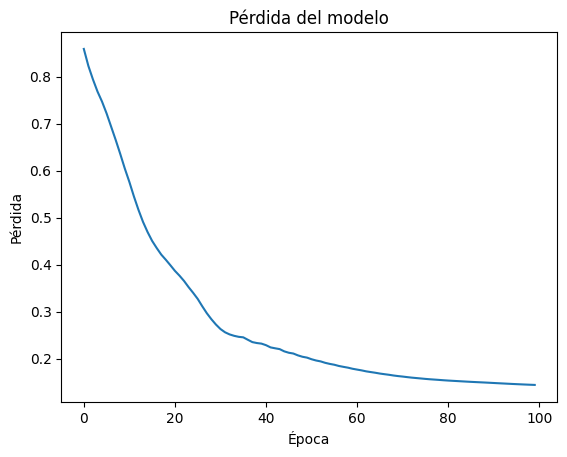

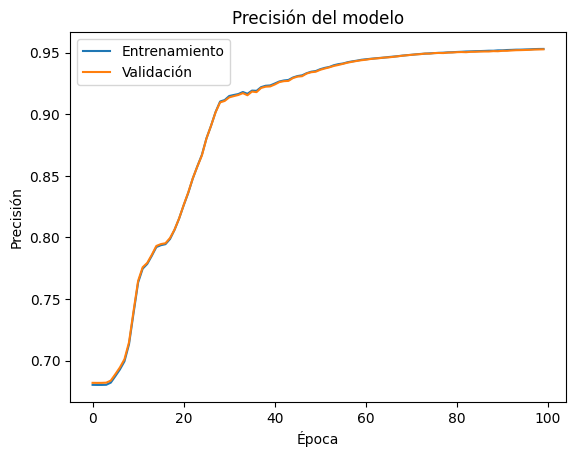

In [3]:

data_path = "datasets/DGL_Graph/MYCODEMultiDiGraph/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dtaset_v2()


edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
# model = GCN(in_feats, h_feats, num_clases)
# pred = DotPredictor()

model = GraphSAGE(gnn.dgl_graph.ndata['feat'].shape[1], 16,8)
pred = MLPPredictor(8,3)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

acc_val = []
acc_train = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  # scores = torch.argmax(logits, dim=1)
  scores = logits.argmax(1)
  labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)
  loss = F.cross_entropy(logits[train_mask], labels[train_mask])

  # Almacenar el valor de pérdida
  loss_values.append(loss.item())
  
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = (scores[train_mask] == labels[train_mask]).float().mean().item()

  # Calcular la precisión en el conjunto de validación
  val_acc = (scores[gnn.val_mask] == labels[gnn.val_mask]).float().mean().item()

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}, train acc: {}, val acc: {}'.format(e, loss,train_acc,val_acc))

# Graficar Perdida
plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()


# Graficar la precisión en el conjunto de entrenamiento y validación
plt.figure()
plt.plot(acc_train, label='Entrenamiento')
plt.plot(acc_val, label='Validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()



CALCULO
ELSE
Classification Report:

              precision    recall  f1-score   support

           0     0.9593    0.9772    0.9681    125344
           1     0.9381    0.9013    0.9193     29649
           2     0.9382    0.9009    0.9192     29649

    accuracy                         0.9527    184642
   macro avg     0.9452    0.9265    0.9355    184642
weighted avg     0.9525    0.9527    0.9524    184642



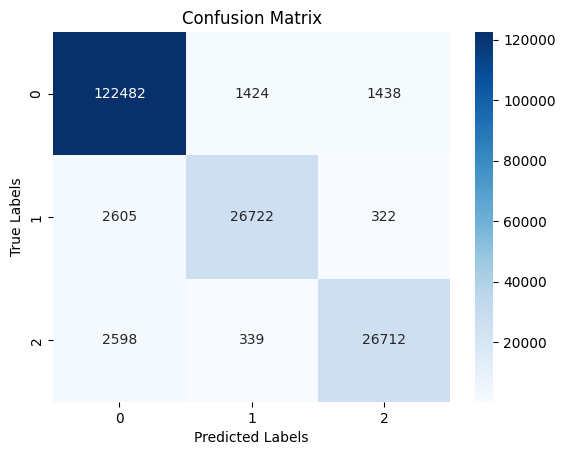

In [4]:
from utils import cal_acc_pres_f1
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]

cal_acc_pres_f1(predicted_scores,true_labels, threshold=None)

# Caso 2: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : MLPPredictor
    

## Entrenamiento

Done saving data into cached files.
None
In epoch 0, loss: 136.74351501464844
In epoch 10, loss: 9.839287757873535
In epoch 20, loss: 1.9533271789550781
In epoch 30, loss: 1.2300705909729004
In epoch 40, loss: 1.077202558517456
In epoch 50, loss: 0.9962959289550781
In epoch 60, loss: 0.9377821087837219
In epoch 70, loss: 0.8992254137992859
In epoch 80, loss: 0.8751108646392822
In epoch 90, loss: 0.8577592372894287


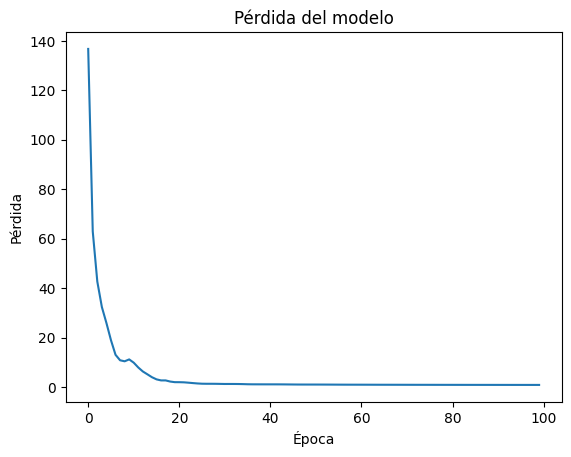

In [4]:

data_path = "datasets/DGL_Graph/MYCODEMultiDiGraphDegree/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() # FIXME:

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
# model = GCN(in_feats, h_feats, num_clases)
# pred = DotPredictor()

model = GraphSAGE(gnn.dgl_graph.ndata['feat'].shape[1], 16,8)
pred = MLPPredictor(8,3)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  # scores = torch.argmax(logits, dim=1)
  scores = logits.argmax(1)
  labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)
  loss = F.cross_entropy(logits[train_mask], labels[train_mask])

  # Almacenar el valor de pérdida
  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

# #     # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# # # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')



plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()


CALCULO
ELSE
Classification Report:

              precision    recall  f1-score   support

           0     0.6803    0.9972    0.8088    251083
           1     0.3595    0.0064    0.0125     59105
           2     0.8984    0.0037    0.0074     59183

    accuracy                         0.6795    369371
   macro avg     0.6460    0.3358    0.2762    369371
weighted avg     0.6639    0.6795    0.5530    369371



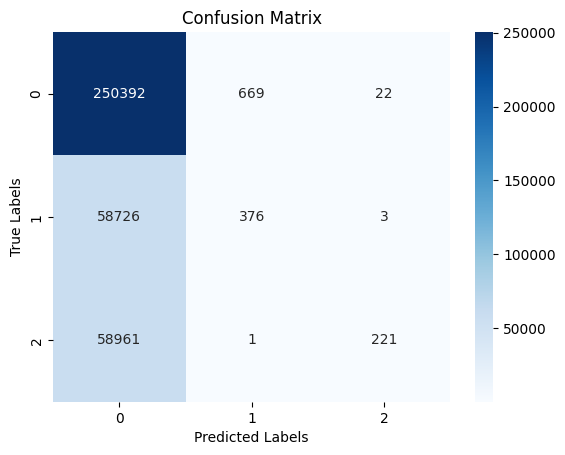

In [5]:
from utils import cal_acc_pres_f1
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
cal_acc_pres_f1(predicted_scores,true_labels, threshold=None)

# Caso 3: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [6]:
# CReate data graph  with only features designated

# Path de donde se guardaran archivos
path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEMultiDiGraph/"  


graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)

# 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
LIST_FEATURES_CATEG = ['AS_rank_continent',
                        'peeringDB_info_ratio',
                        'peeringDB_info_scope',
                        'peeringDB_info_type',
                        'peeringDB_policy_general'
                        'ASDB_C1L1']

# Crear Di graph 
list_feat = ['AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']  +  LIST_FEATURES_CATEG
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[SAVE : c:\Users\Vale\Desktop\GIT\TESIS/datasets/DGL_Graph/MYCODEMultiDiGraph/edges.csv]
MultiDiGraph with 74145 nodes and 923778 edges
MultiDiGraph with 74145 nodes and 923778 edges
MultiDiGraph with 74145 nodes and 923778 edges
MultiDiGraph with 74145 nodes and 923778 edges


Done saving data into cached files.
None
In epoch 0, loss: 171.3596649169922
In epoch 10, loss: 15.70785903930664
In epoch 20, loss: 6.734424114227295
In epoch 30, loss: 2.487278461456299
In epoch 40, loss: 1.3759055137634277
In epoch 50, loss: 1.1562647819519043
In epoch 60, loss: 0.9343445301055908
In epoch 70, loss: 0.8527824878692627
In epoch 80, loss: 0.7944784760475159
In epoch 90, loss: 0.7671604752540588


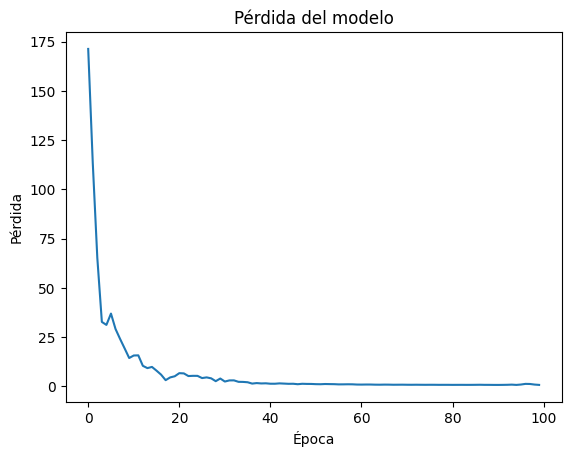

In [7]:
data_path = "datasets/DGL_Graph/MYCODEMultiDiGraphDegree/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() # FIXME:

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
# model = GCN(in_feats, h_feats, num_clases)
# pred = DotPredictor()

model = GraphSAGE(gnn.dgl_graph.ndata['feat'].shape[1], 16,8)
pred = MLPPredictor(8,3)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  # scores = torch.argmax(logits, dim=1)
  scores = logits.argmax(1)
  labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)
  loss = F.cross_entropy(logits[train_mask], labels[train_mask])

  # Almacenar el valor de pérdida
  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

# #     # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# # # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')



plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

CALCULO
ELSE
Classification Report:

              precision    recall  f1-score   support

           0     0.6881    0.9991    0.8150    251523
           1     0.7945    0.0459    0.0867     59091
           2     0.7681    0.0110    0.0217     58804

    accuracy                         0.6893    369418
   macro avg     0.7503    0.3520    0.3078    369418
weighted avg     0.7179    0.6893    0.5722    369418



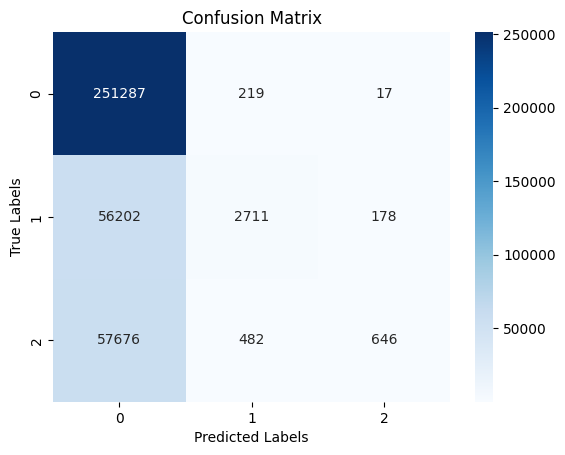

In [5]:
from utils import cal_acc_pres_f1
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
cal_acc_pres_f1(predicted_scores,true_labels, threshold=None)

# BGP2VEC

## Crear Emberddings

In [6]:
# Embeddings ASN BGP2VEC
import os
from bgp2vec.bgp2vec import BGP2VEC
from gensim.models import Word2Vec

oix_path = os.getcwd()+  "/datasets/RouteViews/Download/oix-full-snapshot-2022-06-30-2000.bz2"
test_limit = 2000000 #cantidad paths/horaciones
mode = None# 'test' # par limitar cantidad de paths/oraciones
epochs = 1
debug = True
model_path = os.getcwd()+"/bgp2vec/bgp2vec.word2vec"

# Crea embeddings de ASN con  BGP2VEC y lo guarda en "/bgp2vec/bgp2vec.word2vec"
bgp2vec = BGP2VEC(model_path = model_path ,oix_path=oix_path,rewrite=True, test_limit= test_limit, mode = mode, epochs = epochs)

print("[MODELO]",bgp2vec.model)
print("[TOTAL ASN]",bgp2vec.model.corpus_total_words)

# index = bgp2vec.model.wv['701']
# print(f"[INDEX ASN {'701'}] {index}")
# print(f"[INDEX ASN {'701'}] {bgp2vec.asn2vec('701')}")
# print("IMPOT ")
# MODELS_PATH = os.getcwd() + "/bgp2vec/bgp2vec.word2vec"
# print(f"PATH {MODELS_PATH}")
# BGP2Vec_model = Word2Vec.load(MODELS_PATH)

Warning! PYTHONHASHSEED is not defined


## Importar Embeddings

In [ ]:
MODELS_PATH = os.getcwd() + "/bgp2vec/bgp2vec.word2vec"

# Importar embeddings ASN
BGP2Vec_model = Word2Vec.load(MODELS_PATH)

emdeddings = BGP2Vec_model.wv.vectors
total_ASNs, embedding_vecor_length = emdeddings.shape

print(f"[TOTAL ASN]: {total_ASNs}" )

print(f"[EMBEDDINGS LEN]: {embedding_vecor_length}")
print(f"[EMBEDDINGS] {emdeddings}")

[TOTAL ASN]: 74238
[EMBEDDINGS LEN]: 32
[EMBEDDINGS] [[-2.1472703e-01  6.3407493e-01  2.6631510e-01 ... -6.7314707e-02
   5.2685094e-01  9.1462356e-01]
 [-1.3031145e+00  8.3815610e-01  5.3771269e-01 ... -2.9695952e-01
  -2.3368393e-01  4.5706276e-02]
 [-7.9452795e-01  5.5671680e-01 -6.1896056e-01 ... -2.6427367e-01
  -2.6843885e-01  1.3504244e+00]
 ...
 [-1.1700593e-02 -1.3378471e-02  5.4460280e-03 ...  2.8491393e-04
  -1.2418743e-02  2.4866499e-03]
 [ 2.3998376e-02  1.9970149e-02 -2.5604732e-02 ...  1.7985072e-02
   5.2202269e-03 -3.0413084e-02]
 [ 7.9072835e-03 -3.8274422e-02 -4.1166581e-02 ...  3.5102013e-02
   9.1040730e-03 -3.5600732e-03]]


## Dataset AS Relationships

In [ ]:
from utils import edges_and_relationships_from_dgl_graph


In [ ]:
# Datset TOR
data_path = "datasets/DGL_Graph/MYCODEMultiDiGraph/"
gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0

list_edges, labels = edges_and_relationships_from_dgl_graph(gnn.dgl_graph)

print("[EDGES]\n",list_edges)
print("[LABELS]", labels)

Done saving data into cached files.
None
[EDGES]
 [[    0  2858]
 [    0  4919]
 [    0 21556]
 ...
 [ 6630 74143]
 [73477 74143]
 [73870 74143]]
[LABELS] [0 0 0 ... 2 2 2]


## Split Dataset

In [ ]:
TEST_SIZE = 0.2
# Generat indices para dataset
indices = np.arange(len(list_edges))

x_training, x_test, indices_training, indices_test = train_test_split(list_edges, indices, test_size=TEST_SIZE) 
y_training = labels[indices_training]
y_test = labels[indices_test]

In [ ]:
print("[TRAINING]" ,x_training.shape, y_training.shape)
print("[TEST]",x_test.shape, y_test.shape)

print("[TRAINIG %]",1.0*len(x_training)/(len(x_test)+len(x_training)))

from collections import Counter
training_c = Counter(y_training)
test_c = Counter(y_test)
print("[COUNTER TRAINING]",training_c)
print("[COUNTER TEST]",test_c)

[TRAINING] (739022, 2) (739022,)
[TEST] (184756, 2) (184756,)
[TRAINIG %] 0.7999995669955335
[COUNTER TRAINING] Counter({0: 502657, 2: 118289, 1: 118076})
[COUNTER TEST] Counter({0: 125721, 1: 29624, 2: 29411})


## Modelo NN

In [ ]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)
# !pip uninstall torch -y   # py -m pip uninstall tensorflow -y

# pip install torch==2.4 # py -m pip install tensorflow==2.4
# pip install tensorflow==1.13.1

2.17.0
3.5.0


In [ ]:
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
# from keras.layers import LSTM
# from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Embedding
# from keras.preprocessing import sequence
# from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import to_categorical
from keras.callbacks import TensorBoard,ModelCheckpoint

In [ ]:
# Configuración de la RNN BGP2VEC
experiment = None

embedding_trainable = False
input_length = 2
num_classes = 3
embedding_vector_length = 32  # Corrige el error tipográfico
total_ASNs = 74238
MODEL_NAME = "Model_bgp_"

# Registro de parámetros del experimento si es aplicable
if experiment is not None:
    experiment.log_parameter("embedding_trainable", embedding_trainable)

# Definición del modelo
model = Sequential()
model.add(Embedding(total_ASNs, embedding_vector_length, input_length=input_length,
                    weights=[emdeddings], trainable=True))  # Asegúrate de que 'emdeddings' esté definida
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))

model.add(Reshape((32, 2)))  # Cambia Reshape para reflejar las dimensiones correctas
#model.add(Reshape((model.output_shape[2], model.output_shape[1])))  # Cambia Reshape para reflejar las dimensiones correctas
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Reshape((32,16)))  # Cambia Reshape para reflejar las dimensiones correctas
#model.add(Reshape((model.output_shape[2], model.output_shape[1])))  # Cambia Reshape para reflejar las dimensiones correctas
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
print(model.summary())


c:\Users\Vale\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,375,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,375,616 (9.06 MB)

 Trainable params: 2,375,616 (9.06 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Convert class vectors to binary class matrices
y_training_vector = to_categorical(y_training, num_classes)
y_test_vector = to_categorical(y_test, num_classes)



In [ ]:
# Use class_weight to deal with unbalanced dataset
from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced', list(range(num_classes)), y_training)
# print(class_weights)
class_weights = None

In [ ]:
# Fit model
checkpointer_acc = ModelCheckpoint(monitor='val_acc', filepath= os.getcwd() + "/bgp2vec/" + MODEL_NAME + '_acc.weights.h5',
                                    verbose=1, 
                                    save_best_only=True, 
                                    save_weights_only=True)

checkpointer_loss = ModelCheckpoint(filepath= os.getcwd() + "/bgp2vec/" + MODEL_NAME + '_loss.weights.h5', 
                                    verbose=1, 
                                    save_best_only=True, 
                                    save_weights_only=True)

callbacks = [checkpointer_loss,checkpointer_acc] #tensorboard

In [ ]:
import math
experiment = None
epochs = 40 #################################   3  ##########
if experiment is not None:
    experiment.log_parameter("epochs", epochs)

batch_size = 64
if experiment is not None:
    experiment.log_parameter("batch_size", batch_size)

steps_per_epoch = math.ceil(len(x_training)/batch_size)
if experiment is not None:
    experiment.log_parameter("steps_per_epoch", steps_per_epoch)

val_batch_size = 1024
if experiment is not None:
    experiment.log_parameter("val_batch_size", val_batch_size)

validation_steps = math.ceil(len(x_test)/val_batch_size)
if experiment is not None:
    experiment.log_parameter("validation_steps", validation_steps)

def val_generator(features, labels, val_batch_size):
    index = 0
    while True:
        index += val_batch_size
        batch_features, batch_labels = features[index-val_batch_size:index], labels[index-val_batch_size:index]
        if index >= len(features):
            index = 0
        yield batch_features, batch_labels
        
def generator(features, labels, batch_size):
    index = 0
    while True:
        index += batch_size
        if index >= len(features):
            batch_features = np.append(features[index-batch_size:len(features)], features[0:index-len(features)], axis=0)
            batch_labels = np.append(labels[index-batch_size:len(features)], labels[0:index-len(features)], axis=0)
            index -= len(features)
            yield batch_features, batch_labels
        else:
            yield features[index-batch_size:index], labels[index-batch_size:index]


In [ ]:
# if experiment is not None:
#     with experiment.train():
#         history = model.fit_generator(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
#                         epochs=epochs, callbacks=callbacks, class_weight=class_weights,
#                         validation_data=val_generator(x_test, y_test_vector,val_batch_size), 
#                         validation_steps=validation_steps)
# else:
#     history = model.fit_generator(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
#                         epochs=epochs, callbacks=callbacks, class_weight=class_weights,
#                         validation_data=val_generator(x_test, y_test_vector,val_batch_size), 
#                         validation_steps=validation_steps)

if experiment is not None:
    with experiment.train():
        history = model.fit(
            x=val_generator(x_training, y_training_vector, batch_size),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
            validation_data=val_generator(x_test, y_test_vector, val_batch_size),
            validation_steps=validation_steps
        )
else:
    history = model.fit(
        x=val_generator(x_training, y_training_vector, batch_size),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights,
        validation_data=val_generator(x_test, y_test_vector, val_batch_size),
        validation_steps=validation_steps
    )


Epoch 1/40
11548/11548 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8931 - loss: 0.2910
Epoch 1: val_loss improved from inf to 0.11669, saving model to c:\Users\Vale\Desktop\GIT\TESIS/bgp2vec/Model_bgp__loss.weights.h5
11548/11548 ━━━━━━━━━━━━━━━━━━━━ 219s 19ms/step - accuracy: 0.8931 - loss: 0.2910 - val_accuracy: 0.9622 - val_loss: 0.1167
Epoch 2/40
    7/11548 ━━━━━━━━━━━━━━━━━━━━ 3:51 20ms/step - accuracy: 0.9605 - loss: 0.0866

c:\Users\Vale\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


  445/11548 ━━━━━━━━━━━━━━━━━━━━ 3:29 19ms/step - accuracy: 0.9640 - loss: 0.1138

KeyboardInterrupt: 

## Plot history accuracy

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


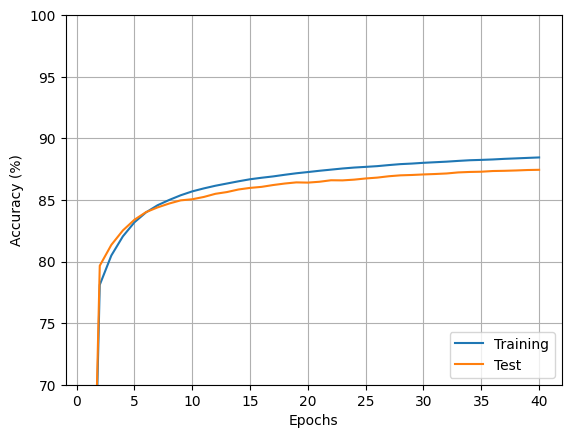

In [ ]:
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


with open(os.getcwd() + "/bgp2vec/results_" + MODEL_NAME +  "_accuracy.pkl", 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)
    if experiment is not None:
        experiment.log_asset(os.getcwd() + "/bgp2vec/results_" + MODEL_NAME +  "_accuracy.pkl")
    
# list all data in history
print(history.history.keys())
x = np.asarray(range(1,epochs + 1))
# summarize history for accuracy
plt.figure()
plt.plot(x, smooth([y*100 for y in history.history['accuracy']],2))
# plt.plot(x, [y*100 for y in history_history['val_acc']])
plt.plot(x, smooth([y*100 for y in history.history['val_accuracy']],2))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim(70,100) ###########################
plt.legend(['Training', 'Test'], loc='lower right')
plt.grid()
plt.savefig(os.getcwd() + "/bgp2vec/results_" + MODEL_NAME +  " accuracy history", bbox_inches='tight')
if experiment is not None:
    experiment.log_image(os.getcwd() + "/bgp2vec/results_" + MODEL_NAME + " accuracy history.png")
plt.show()

## Final evaluation of the model

In [ ]:
# Evaluate accuracy over the test set
# model.load_weights(MODELS_PATH + MODEL_NAME + '_acc.hdf5')
# model.load_weights(os.getcwd() + "/bgp2vec/" + MODEL_NAME + '_acc.weights.h5')

In [ ]:
test_scores = model.evaluate(x_test, y_test_vector, batch_size=val_batch_size, verbose=1)
    
    
print("Accuracy: %.2f%%" % (test_scores[1]*100))

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8762 - loss: 0.3372
Accuracy: 87.59%


In [ ]:
# y_test_prediction = model.predict_classes(x_test, batch_size=val_batch_size, verbose=1)
y_test_predictions_prob = model.predict(x_test, batch_size=val_batch_size, verbose=1)
# Obtener las clases predichas
y_test_prediction = np.argmax(y_test_predictions_prob, axis=1)

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# y_training_prediction = model.predict_classes(x_training, batch_size=val_batch_size, verbose=1)
y_training_predictions_prob = model.predict(x_training, batch_size=val_batch_size, verbose=1)
# Obtener las clases predichas
y_training_prediction = np.argmax(y_training_predictions_prob, axis=1)

722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [ ]:
#Test if by learning (asn1, asn2) -> p2c then (asn2, asn1) -> c2p and vice versa


p2c = 2
c2p = 1

p2c_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2c])
p2c_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2c_training])

p2c_training_label_vector = to_categorical([p2c]*len(p2c_training), num_classes)
p2c_training_oposite_label_vector = to_categorical([c2p]*len(p2c_training_oposite), num_classes)

print(p2c_training.shape, p2c_training_oposite.shape, p2c_training_oposite_label_vector.shape)


(118229, 2) (118229, 2) (118229, 3)


In [ ]:
p2c_training_scores = model.evaluate(p2c_training, p2c_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_scores[1]*100))

p2c_training_oposite_scores = model.evaluate(p2c_training_oposite, p2c_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_oposite_scores[1]*100))

3695/3695 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7575 - loss: 0.6083
Accuracy: 75.65%
3695/3695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6911 - loss: 0.7303
Accuracy: 69.27%


In [ ]:
#Test if by learning (asn1, asn2) -> p2p then (asn2, asn1) -> p2p and vice versa

p2p = 0

p2p_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2p])
p2p_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2p_training])

p2p_training_label_vector = to_categorical([p2p]*len(p2p_training), num_classes)
p2p_training_oposite_label_vector = to_categorical([p2p]*len(p2p_training_oposite), num_classes)




In [ ]:
p2p_training_scores = model.evaluate(p2p_training, p2p_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_scores[1]*100))

p2p_training_oposite_scores = model.evaluate(p2p_training_oposite, p2p_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_oposite_scores[1]*100))


15709/15709 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9642 - loss: 0.1259
Accuracy: 96.39%
15709/15709 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.9630 - loss: 0.1294
Accuracy: 96.29%


## Plot and save a confusion matrix for results over the test set

In [ ]:
# Define a function
%matplotlib inline

import matplotlib
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow([[100*j for j in i] for i in cm], interpolation='nearest', cmap=cmap)
        cbar = plt.colorbar()
        cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(fname, bbox_inches='tight')

In [ ]:
class_names = ['P2P', 'C2P', 'P2C']

Confusion matrix, without normalization
Normalized confusion matrix


C:\Users\Vale\AppData\Local\Temp\ipykernel_14884\276448347.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])


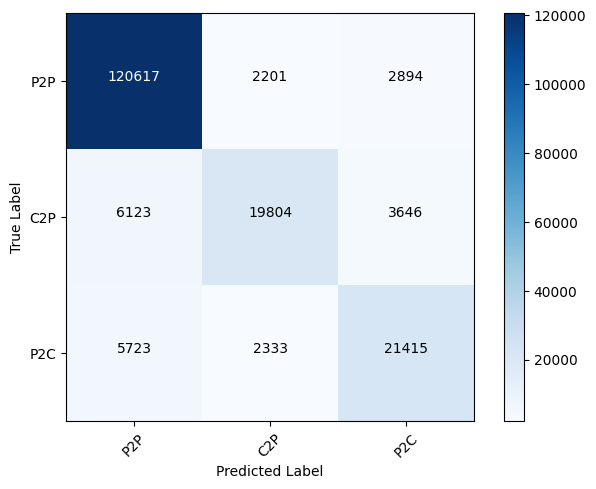

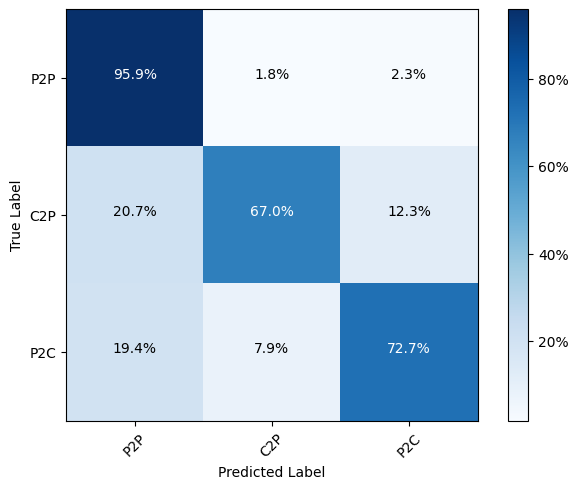

In [ ]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=os.getcwd()+ "/bgp2vec/results_"  + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')
if experiment is not None:
    experiment.log_image(os.getcwd()+ "/bgp2vec/results_"  + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization.png', 
                         name='Confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Msatrix',
                      fname=os.getcwd()+ "/bgp2vec/results_"  +MODEL_NAME + "_" + 'Normalized_confusion_matrix')

if experiment is not None:
    experiment.log_image(os.getcwd()+ "/bgp2vec/results_" + MODEL_NAME + "_" + 'Normalized_confusion_matrix.png',
                         name='Normalized_confusion_matrix.png')

plt.show()


Confusion matrix, without normalization
Normalized confusion matrix


C:\Users\Vale\AppData\Local\Temp\ipykernel_14884\276448347.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])


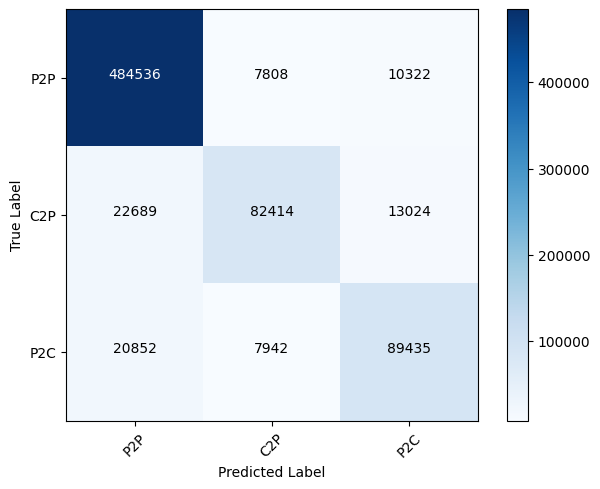

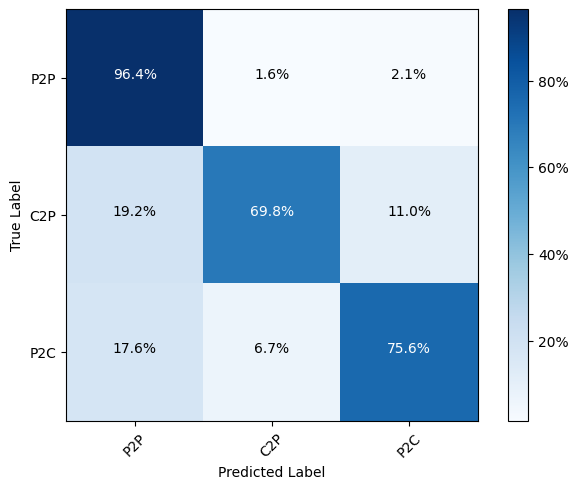

In [ ]:
# Plot cm for training set

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_training, y_training_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname= os.getcwd() + "/bgp2vec/result_" + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization')
if experiment is not None:
    experiment.log_image(os.getcwd() + "/bgp2vec/result_"  + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix',
                      fname=os.getcwd() + "/bgp2vec/result_"  +MODEL_NAME + "_" + 'training_Normalized_confusion_matrix')
if experiment is not None:
    experiment.log_image(os.getcwd() + "/bgp2vec/result_"  + MODEL_NAME + "_" + 'training_Normalized_confusion_matrix.png')

plt.show()

In [ ]:
# TODO: Se siguen entrenando los embeddings en la RNN
# TODO: porque no se esta guardando acc del modelo por batch
# TODO: Diferencia entre test y val